# Visualizing sequence data with Matplotlib

##### *The dirty way*

There are probably many packages that take multiple sequences alignment and draw a pretty nice little visualization. However as a software engineer and bioinformatician, our time is probably better spend on algorithm than learning new packages, especially when it pretty one off. Furthermore, sometime it is important to have more control over our graph, including alignning elements, incorporate different metrics...

In this tutorial we will try to visualize a short aa sequence (75 residues) with conservation calculated by norm distance to uniform distribution (it's not the best way to calculate conservation but... it's quick and dirty). Finally we display a concensus sequence, which is the most relevant amino acid at each residue. Again this is not biologically correct, but that beside the point. You should be able quickly adapt this script to work on different data and different metrics

## The idea

The idea behind this notebook is as we plot statistic at each residue, we draw the sequence directly underneath it. The reason this method even work is matplotlib draw on the figure in "ticks space", as in the distance on the plot is calculated in data steps.

So if we have a bar graph, we can quickly align vertically a text object simply by putting ````plot.text()```` at exactly x. Conversely of y, we need to calculate an offset from the bottom of the graph to the position we want to draw our text/residue/nucleotide acid. That simple.

## Prequisite
1. The necessary libraries
We need the following libraries: matplotlib (duh), BioPython and NumPy. BioPython is needed to effectively manage our MSA, although with parser and hard work you can read directly from fasta file. NumPy is needed to interface with matplotlib, and in general, who would not include NumPy in their tutorial these day

In [1]:
import numpy as np, Bio, matplotlib.pyplot as plot
from matplotlib.ticker import FormatStrFormatter
from Bio import SeqIO

%matplotlib inline

2. In order to display the sequence in a format we familiar with we need 2 things. First, because we intent to visualize our sequences in a sequence of boxes, each box represent a residue and we want the boxes to be align, we need a monospacing font family

In [2]:
font = {'family': 'monospace',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

Secondly we need a color palette. There are 20 amino acid and one color for gap, which is displayed as a dash. The color I use here is a color palette used by RasMol package (holy f it's old)

In [3]:
palette = ['#C8C8C8', '#145AFF', '#00DCDC', '#E60A0A', '#E6E600', '#00DCDC', '#E60A0A', '#EBEBEB', '#8282D2', '#0F820F', '#0F820F', '#145AFF', '#E6E600', '#3232AA', '#DC9682', '#FA9600', '#FA9600', '#B45AB4', '#3232AA', '#0F820F', '#FFFFFF']

Finally we have a string of all possible amino acid + the gap

In [4]:
aa = 'ARNDCQEGHILKMFPSTWYV-'

## Reading stuff...

First thing first: we read our MSA with the most basic numbers: length and number of sequences

In [5]:
fasta_file = 'src/Inputs/example/1atzA.fas'
msa = list(SeqIO.parse(fasta_file,'fasta'))
L = len(msa[0].seq)
N = len(msa)

We calculate the frequency of each amino acid occurs at each residue next. We also calucate the concensus sequence at this stage

In [6]:
freq = np.zeros([L,21])
concensus = np.zeros(L)
for i in range(0,N):
    for j in range(0,L):
        j_aa = aa.find(msa[i].seq[j])
        freq[j,j_aa] = freq[j,j_aa] + 1
for i in range(0, L):
    concensus[i] = freq[i].argmax()

The algorithm is simple. 

Next come the conservation. The formular for conservation is:
$$
C_i = \sum_{j}^{j=N}\sqrt{(\frac{f_j}{N} - 0.05)^2}
$$

For $C_i$ is the conservation value of $i^{th}$ residue.

Why 0.05? Because it's 1/20, and guess how many amino acid there is.

*(of course there are 21 possible values but this function wrong enough lol)*

In [7]:
conservation = np.sqrt(np.sum((np.square(freq/N - 0.05)),axis=1))

## Now, the fun part: Actually drawing the MSA.

Because there is no native way to draw all the thing that go into this visualization, it look a bit messy. And also because all of this is quick, dirty, this will probably not the best way to do thing. But it's a way.

*Notes: I put *````figure````* in places where I want to draw the figure **for demonstration purpose**. You may want to remove them when you recombine the code boxes in your notebook, otherwise it will draw multiple graph. On itself.*

First, we create  the figure with its axes. The figure is configured to be ultra wide, because the sequences are long *wink wink*.

In [34]:
figure = plot.figure(figsize=(20,2))
axes = plot.axes([0,0,1,1]);
plot.close()

Now, to draw the conservation graph. It's a simple bargraph which display at each residue what is the conservation rate according to the formular provided previously.

Reminder: to call bargraph: ````axes.bar(range,data,**args)````. It is also important to have ````align='edge', linewidth=0```` for alignment purpose. ````align='edge'```` make the bar aligned on the right of the ticks, and ````linewidth=0```` make the spacing between ticks correct.

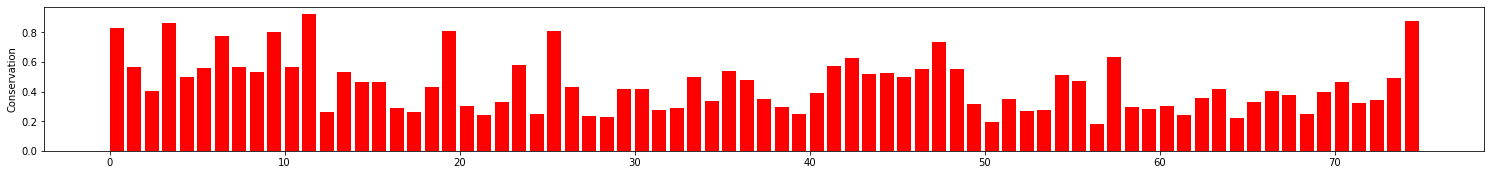

In [35]:
axes.bar(range(0,L),conservation, align='edge', linewidth = 0, color = 'red')
axes.set_ylabel('Conservation')
figure

Next step we draw the sequences. We choose randomly 5 sequences from the MSA, because to display all 1000 MSA of this dataset is simply ... unrealistic. We also calculate the spacing between each sequences, as well as spacing between the bottom of the conservation graph to the first sequence displayed.

The spacing scale is calculated by taking the limit of y and divided by 6. Why? Because it work for our particular font and spacing...

In [10]:
spacing_scale = axes.get_ylim()[1]/6
spacing = spacing_scale*2

seq_display = np.sort(np.random.randint(0,N,[5]))

So now, where to draw our sequence? For each sequence we calculate the y-offset from $(0, 0)$ position in data space. Then the x position of each residue is simply its position in the sequence... Prety neat indeed.

The following code block go like: For each sequence, calculate the basic position (0,posit), where posit = the place of sequence times the scale minus an offset. ````axes.text()```` is called to draw the sequence title. Finally, each residue is draw by ````axes.text()```` with the x position is the position of the residue itself, and a bbox draw over the text. We feed the bbox the color according to the palette, and an ````alpha=0.5```` so it's see through.

Oh, and remember to add ````fontdict=font```` for our monospacing font set

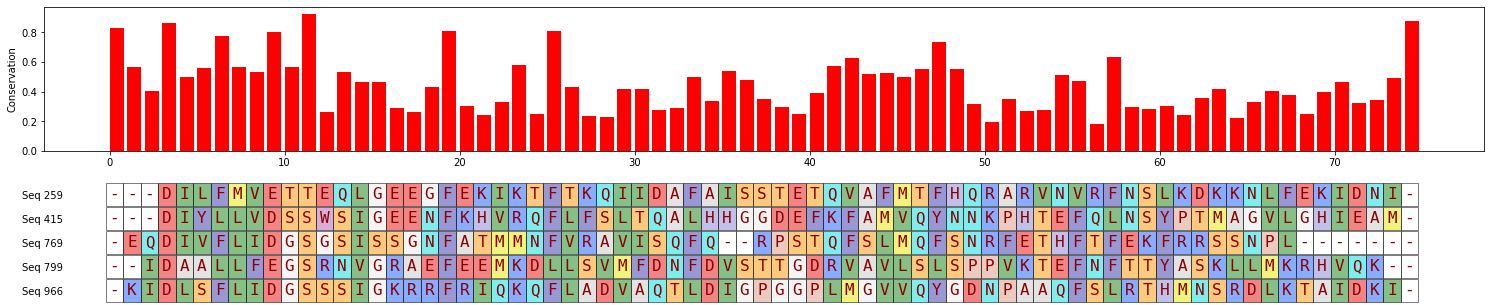

In [11]:
for j in seq_display:
    posit = -float(np.where(seq_display == j)[0]) * spacing_scale - spacing
    axes.text(-5,posit, "Seq "+(str(j+1)))
    for i in range(0, L):
        # print(i/20,j/4)
        axes.text(float(i),posit, msa[j].seq[i],
            bbox=dict(facecolor=palette[aa.find(msa[j].seq[i])], 
            alpha=0.5),fontdict=font)
figure

Finally we add the concensus sequence:

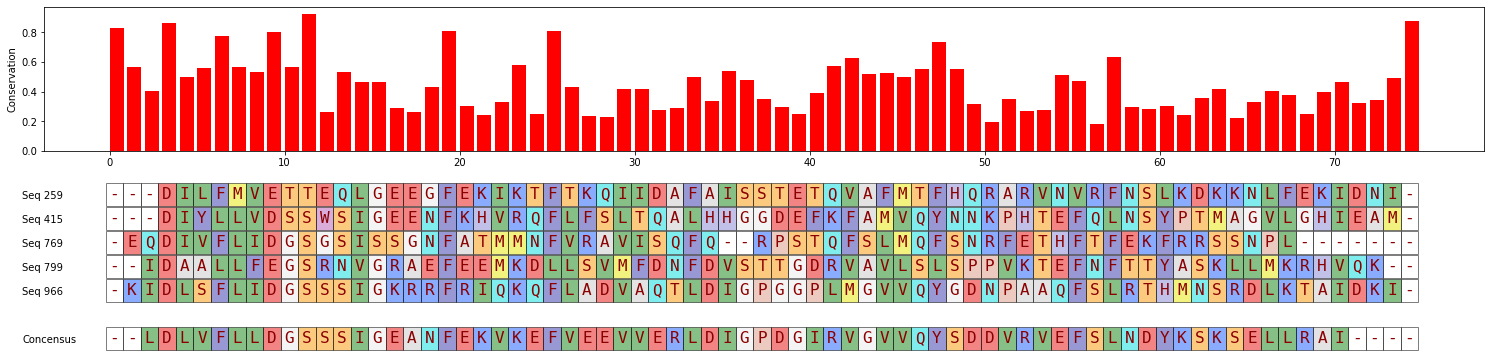

In [12]:
posit = posit - spacing
axes.text(-5,posit, "Concensus")
for i in range(0, L):
    # print(i/20,j/4)
    axes.text(float(i),posit, 'ARNDCQEGHILKMFPSTWYV-'[int(concensus[i])] ,
                bbox=dict(facecolor=palette[int(concensus[i])], 
                alpha=0.5),fontdict=font)
figure

Et voila! There you go, a quick and dirty way to visualize your sequence dataset. The code is (hopefully) simple enough so you can expanse on your own to other type of biological sequence data (Genomics, Trans...), and different graph can also be used as basis for visualizing your MSA. This, however, is not scalable to larger sequences. You will have to experiment on how best to show your data, but that's the fun of bioinfomatics! And now you have all the controls to do so.